In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'
# Change 'Ethiopia_Data' to key of your own sheet in Sheets, above
x = read_sheets(Ethiopia,sheet='Food Expenditures (2015-16)')
x['i'] = x['i'].astype(str)
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia,sheet='Food Prices (2015-16)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(Ethiopia,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
#x = x.T.groupby(['i','t','m','j']).sum()
x = x.groupby(['i', 't', 'm', 'j']).sum(numeric_only=True)
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

In [4]:
d.groupby('t').mean()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
t,,,,,,,,,,,,,,,
2011-12,0.000000,0.332397,0.341843,0.272913,0.470258,0.424560,0.201174,0.000000,0.341843,0.368394,0.295124,0.406178,0.378095,0.246362,1.240192
2013-14,0.234645,0.345883,0.349306,0.319643,0.549724,0.436965,0.226849,0.249097,0.357102,0.354440,0.321354,0.467579,0.404640,0.229131,1.407929
2015-16,0.217172,0.340404,0.372727,0.289899,0.498788,0.487677,0.254747,0.240000,0.356364,0.375152,0.312929,0.420000,0.425051,0.207879,1.420437
2018-19,0.216248,0.320384,0.286263,0.280798,0.536780,0.428508,0.173855,0.224963,0.316987,0.293205,0.266470,0.424225,0.402659,0.186706,1.302566


In [5]:
from cfe import Regression
import cfe
result = Regression(y=y,d=d)

In [6]:
result.predicted_expenditures()

i              t        m       j            
1010101601034  2015-16  Tigray  Banana           17.016950
                                Barley           24.326649
                                Beef             67.830699
                                Berbere          30.522978
                                Bread/biscuit    16.765037
                                                   ...    
7221900753163  2015-16  SNNP    Sugar             8.879630
                                Tea               6.069972
                                Teff             69.817516
                                Tomato           11.081318
                                Wheat            23.125252
Length: 128898, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

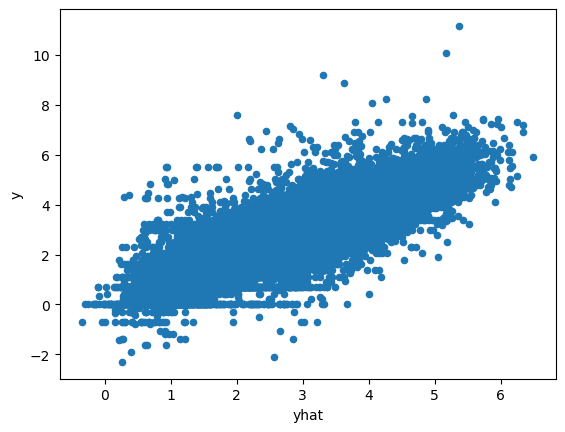

In [7]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

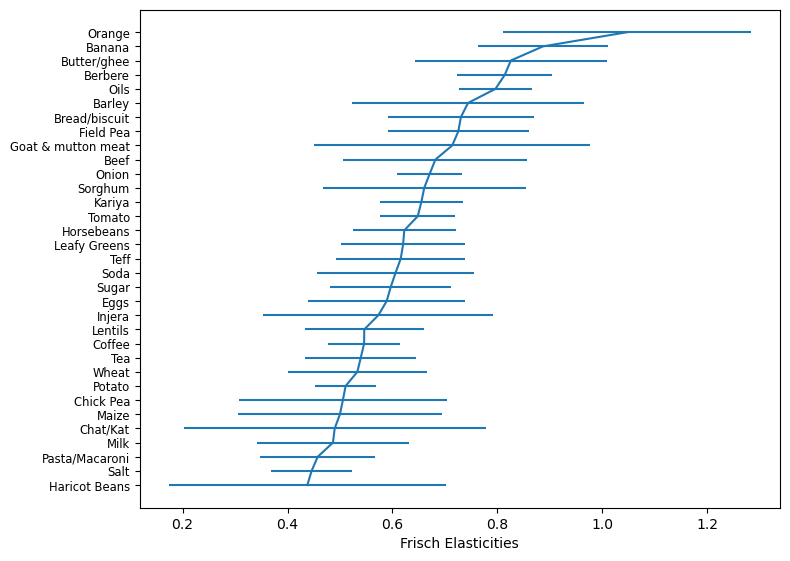

In [8]:
ax = result.graph_beta()

In [9]:
result.get_beta()

j
Banana                0.886952
Barley                0.743966
Beef                  0.681723
Berbere               0.814190
Bread/biscuit         0.730363
Butter/ghee           0.825541
Chat/Kat              0.489810
Chick Pea             0.505407
Coffee                0.545892
Eggs                  0.588911
Field Pea             0.725542
Goat & mutton meat    0.713874
Haricot Beans         0.437647
Horsebeans            0.622453
Injera                0.573011
Kariya                0.654965
Leafy Greens          0.620159
Lentils               0.546167
Maize                 0.499763
Milk                  0.486525
Oils                  0.796363
Onion                 0.670982
Orange                1.047139
Pasta/Macaroni        0.457429
Potato                0.510617
Salt                  0.445803
Soda                  0.605817
Sorghum               0.660504
Sugar                 0.596649
Tea                   0.539507
Teff                  0.615684
Tomato                0.648224
Wheat 

In [10]:
result.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,-0.099900,-0.085549,-0.052286,0.123071,0.141505,0.090880,0.006259,0.040433,-0.149601,-0.088564,0.012523,0.154307,0.249322,-0.044036,0.020647,2.417714
Barley,-0.028100,-0.032862,0.108520,0.063516,0.095259,0.124960,0.084398,0.081119,-0.115425,-0.124752,0.131999,0.029233,0.004516,0.042407,0.273463,2.878666
Beef,-0.170350,-0.065408,-0.026148,0.009565,0.088892,0.151100,-0.082833,0.007332,-0.123413,-0.188317,-0.047031,0.141809,0.163976,0.029518,0.345123,4.561749
Berbere,-0.132447,-0.069849,-0.082520,0.020379,0.138132,0.153889,0.010657,-0.053400,-0.059658,-0.167760,-0.003390,0.066383,0.073580,-0.091642,0.201298,2.975229
Bread/biscuit,-0.156323,-0.077422,0.032862,0.029052,0.048173,0.080348,0.095530,0.066632,0.001453,-0.024167,0.097512,0.129195,0.195461,-0.050622,0.189085,2.722064
Butter/ghee,0.061463,-0.059766,0.081068,0.017550,0.279352,0.128621,0.043256,-0.024525,-0.059100,0.069607,-0.013074,0.178355,0.120341,-0.189328,-0.081227,3.625285
Chat/Kat,0.111276,-0.005009,-0.007693,-0.116397,-0.073373,-0.143418,-0.055915,0.039391,0.004379,0.034836,-0.053028,0.200069,0.195315,0.016835,0.258497,4.424838
Chick Pea,-0.172845,-0.010086,0.068772,0.019920,0.063589,0.112845,0.007074,-0.044518,-0.085505,0.026145,0.003450,0.088796,0.083455,-0.082422,0.361029,2.770512
Coffee,0.022147,0.001971,-0.012654,0.057050,0.118727,0.122793,0.042214,-0.012956,0.046624,-0.042001,-0.023425,0.126073,0.086995,-0.016788,0.008157,2.981118


<Axes: ylabel='Density'>

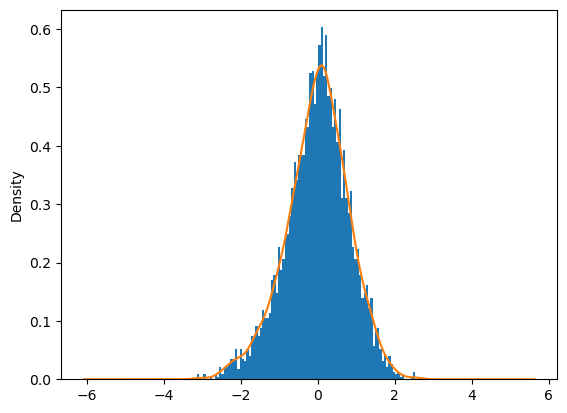

In [11]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [12]:
result.to_pickle('ethiopia_estimate1516.rgsn')

In [14]:
import cfe
result = cfe.regression.read_pickle('ethiopia_estimate1516.rgsn')

In [15]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [16]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [17]:
p

t                        2015-16                                            \
m                    Addis Ababa        Afar      Amhara Benishangul-Gumuz   
j                                                                            
Banana                 15.826637   17.573260   12.932254          8.587535   
Barley                 24.614171   17.250000   29.567850         26.000000   
Beef                 1722.234772  100.000000  123.623585         93.508457   
Beer                 2155.527200   42.207790   49.355336         51.260684   
Berbere               182.433182   99.621469   68.161691         49.386167   
Boye/Yam                     NaN         NaN    6.000000               NaN   
Bread/biscuit          31.274915   15.483389   29.680647          9.154808   
Bula                   76.702749         NaN   12.500000               NaN   
Butter/ghee           165.763462  115.757576  176.092883         82.399997   
Cassava                      NaN         NaN  999.999985               NaN   
Chat/Kat              366.344945  202.432186  204.797740         96.963019   
Cheese                 61.399998         NaN   23.750000               NaN   
Chick Pea              48.272745   17.934640   22.987796         15.000000   
Coffee                131.603912  166.097521  213.000940         65.795897   
Eggs                   33.235946   20.484331   16.820260         15.374999   
Field Pea              46.220793   31.174949   28.247775         26.410256   
Fish                  173.907696         NaN   56.952381         40.000000   
Goat & mutton meat    196.236839  155.874123  184.977757        114.462685   
Godere                       NaN         NaN  124.999998          2.212389   
Ground nuts            62.666664   62.501111   59.157558         20.308623   
Haricot Beans          39.999999    3.000000   12.725265         13.094727   
Horsebeans             31.884520   29.295454   26.591994         23.304065   
Injera                 16.173229   38.582848   21.455276         41.984796   
Kariya                 66.557295   13.997420   15.293996         10.145530   
Kocho                 242.416658         NaN         NaN               NaN   
Leafy Greens           26.374882   15.728927   22.127869         10.972368   
Lentils              1203.420379   49.652172  225.027144         39.294372   
Linseed               207.510999   40.499999   28.758623         26.313131   
Maize                  20.961728    8.779254    6.609729          4.586698   
Milk                   67.144265   38.426469   18.780211         33.980582   
Millet                       NaN         NaN    9.811262          6.820856   
Niger Seed            109.230765         NaN   22.170349         28.483762   
Oils                   45.406229   33.436038   44.460449         31.371034   
Onion                  34.015502   11.479157   10.972513         11.787828   
Orange                 23.558405   26.666666   14.465820          5.086307   
Other cereal           24.006788   18.400000   16.624959               NaN   
Other fruit            24.681818   20.000000   12.110381          8.087607   
Other prepared food    26.523809   38.470716   33.002723         12.584229   
Other pulse or nut     26.858695   44.103847   21.892378         20.660215   
Other seed            323.714271   33.999998   19.356118          6.840109   
Other tuber or stem     9.566335   11.666666   20.303546               NaN   
Other vegetable        18.600000         NaN   14.853881         23.333332   
Pasta/Macaroni        174.356706   27.522727   22.221186         20.150581   
Potato                  9.686409   11.520692    9.044602          9.842611   
Poultry               425.333317         NaN  211.008675        339.583320   
Salt                   23.995758   17.855586   46.878150         14.417005   
Soda                  129.905439   64.912278   45.511835         44.529915   
Sorghum                11.079545   10.144444    9.986363          8.479476   
Sugar                 

Text(0.5, 0, 'Quantities of Banana Demanded')

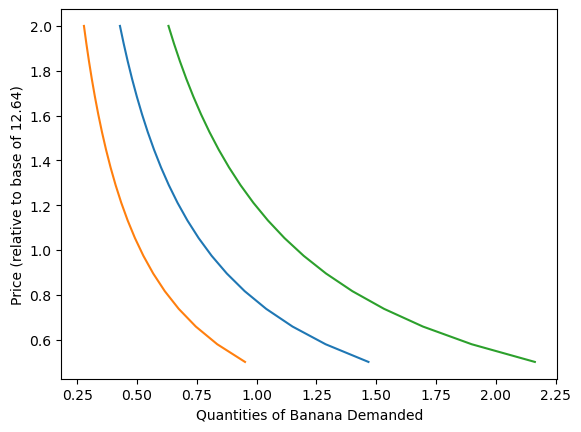

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Banana'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

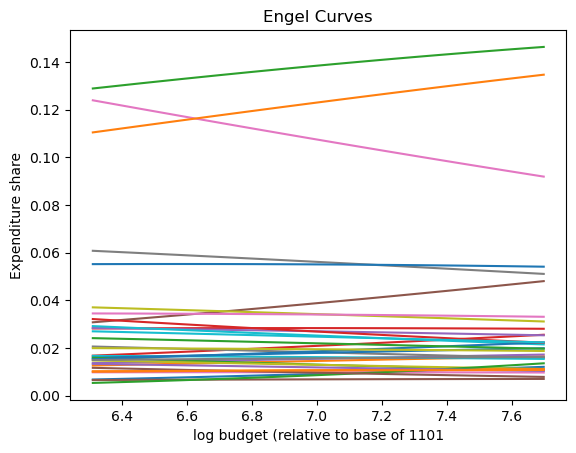

In [20]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

Text(0.5, 1.0, 'Indirect Utility Function')

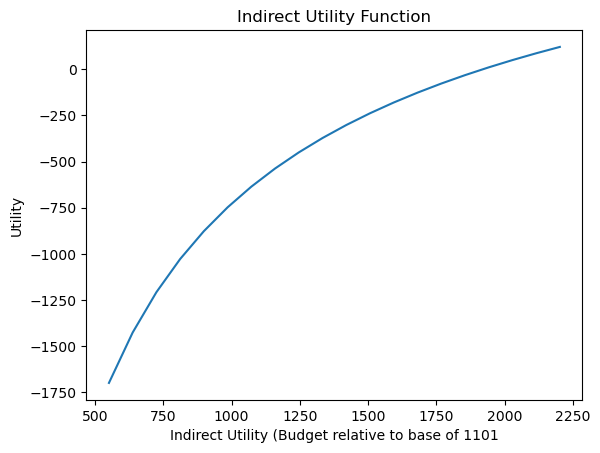

In [21]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')